# COVID-19 CT Scan Classification using VGG16 and Transfer Learning
This notebook demonstrates how to retrain a pre-trained VGG16 model to classify CT scan images into two categories: COVID and Non-COVID. The approach leverages transfer learning, data augmentation, and fine-tuning techniques to achieve effective classification even with a relatively small dataset.

WAP to retrain a pretrained imagenet model to classify a medical image dataset.
Description of the Model :
This project uses transfer learning with the VGG16 model to classify CT scan images into two categories: COVID and Non-COVID. The dataset is organized into two folders and is split into training and validation sets using an 80-20 ratio. Data augmentation techniques like resizing, flipping, and rotation are applied to improve the model's generalization. The original VGG16 layers are mostly frozen to retain learned features, with only the last convolutional block (from layer 24 to 30) fine-tuned. A custom classifier is added to the model to perform binary classification using sigmoid activation.

The model is trained using the Binary Cross Entropy Loss function and optimized with the Adam optimizer. It runs for 20 epochs, tracking both training and validation accuracy and loss. After training, the model is saved for future use, and its performance is visualized using plots. The final accuracy on the validation set is also reported. This approach provides a reliable way to apply deep learning to medical image classification, even with a relatively small dataset.

Description about the code
1. Libraries and Hyperparameters : The script begins by importing essential libraries such as torch, torchvision, and matplotlib. These are used for deep learning, image processing, and plotting. Key hyperparameters like image size, batch size, number of epochs, and learning rate are defined, along with selecting the computation device (GPU if available, else CPU).

2. Data Transformations : To prepare the dataset, two types of image transformations are used. The training data is augmented with resizing, random horizontal flips, and rotations to improve model generalization. Both training and validation data are normalized to match the input requirements of the pre-trained VGG16 model (ImageNet mean and std).

3. Dataset Loading and Splitting : The dataset is loaded from a folder structure using ImageFolder, where each subfolder represents a class (CT_COVID and CT_NonCOVID). The full dataset is split into training and validation sets using an 80-20 split. DataLoader is used to feed images in batches for both training and validation with shuffling enabled for training data.

4. Model Setup: VGG16 : A pre-trained VGG16 model is loaded to leverage features learned from ImageNet. All layers are initially frozen to preserve learned features, except the last convolutional block which is unfrozen for fine-tuning. This allows the model to slightly adapt to the new dataset while retaining most of the pretrained knowledge.

5. Custom Classifier Design : The original classifier of VGG16 is replaced with a custom fully connected network tailored for binary classification. It consists of multiple Linear, ReLU, and Dropout layers, ending in a single neuron with a Sigmoid activation. This outputs a probability between 0 and 1, indicating the class (COVID or Non-COVID).

6. Loss Function and Optimizer : The Binary Cross Entropy Loss (BCELoss) is used since the task is binary classification. The Adam optimizer is chosen for its efficiency and ability to adapt the learning rate. Only the parameters that require gradients (i.e., the unfrozen layers and custom classifier) are passed to the optimizer.

7. Training Loop : The model is trained over 20 epochs. For each batch, it performs a forward pass, computes loss, backpropagates the error, and updates the weights. Training loss and accuracy are tracked after every epoch. The model is then evaluated on the validation set to track performance on unseen data.

8. Validation and Metric Tracking : During validation, the model is set to evaluation mode to prevent dropout and batch norm updates. Accuracy and loss are computed without updating the weights. This helps monitor if the model is overfitting or improving generalization. All metrics are stored for visualization.

9. Saving and Plotting Results : After training is complete, the model is saved to a file named covid_classifier_vgg16.pt for future use. Accuracy and loss trends for both training and validation sets are plotted using matplotlib, helping visualize how the model performed across epochs.

10. Final Evaluation : Lastly, the model is evaluated one final time on the validation set to report its test accuracy. This provides a clear measure of how well the trained model can generalize to new CT scan images. The result is printed to the console for quick assessment.


In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Paths and hyperparameters
base_dir = 'Dataset'  # Should contain CT_COVID and CT_NonCOVID folders
img_size = 224
batch_size = 32
epochs = 20
learning_rate = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Data Transforms
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
# Load Datasets
train_dataset = datasets.ImageFolder(os.path.join(base_dir), transform=train_transforms)
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [4]:
# Load and modify VGG16
base_model = models.vgg16(pretrained=True)

# Freeze all layers
for param in base_model.features.parameters():
    param.requires_grad = False

# Unfreeze last conv block
for param in base_model.features[24:].parameters():
    param.requires_grad = True

# Replace classifier
base_model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(128, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, 1),
    nn.Sigmoid()
)

model = base_model.to(device)

c:\Users\thesu\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\thesu\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# Loss and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [6]:
# Training Loop
train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []

for epoch in range(epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss /= total
    train_acc = correct / total
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_loss /= total
    val_acc = correct / total
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/20 - Train Loss: 0.6686, Train Acc: 0.5695, Val Loss: 0.5853, Val Acc: 0.6779
Epoch 2/20 - Train Loss: 0.5613, Train Acc: 0.7169, Val Loss: 0.4634, Val Acc: 0.8188
Epoch 3/20 - Train Loss: 0.4464, Train Acc: 0.8107, Val Loss: 0.4006, Val Acc: 0.8523
Epoch 4/20 - Train Loss: 0.3602, Train Acc: 0.8526, Val Loss: 0.3727, Val Acc: 0.8389
Epoch 5/20 - Train Loss: 0.2806, Train Acc: 0.8928, Val Loss: 0.3467, Val Acc: 0.8792
Epoch 6/20 - Train Loss: 0.2147, Train Acc: 0.9162, Val Loss: 0.3466, Val Acc: 0.8792
Epoch 7/20 - Train Loss: 0.1714, Train Acc: 0.9497, Val Loss: 0.2693, Val Acc: 0.8926
Epoch 8/20 - Train Loss: 0.1647, Train Acc: 0.9464, Val Loss: 0.4501, Val Acc: 0.8054
Epoch 9/20 - Train Loss: 0.1304, Train Acc: 0.9497, Val Loss: 0.3099, Val Acc: 0.8926
Epoch 10/20 - Train Loss: 0.0991, Train Acc: 0.9581, Val Loss: 0.4348, Val Acc: 0.8322
Epoch 11/20 - Train Loss: 0.0793, Train Acc: 0.9732, Val Loss: 0.3388, Val Acc: 0.8322
Epoch 12/20 - Train Loss: 0.0636, Train Acc: 0.9832,

In [7]:
# Save model
torch.save(model.state_dict(), 'covid_classifier_vgg16.pt')

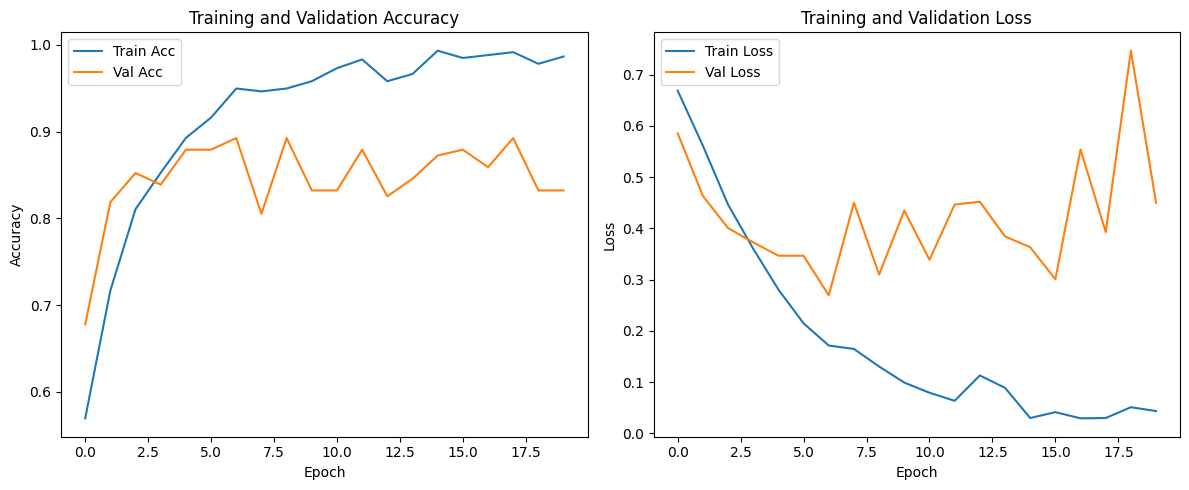

In [8]:
# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train Acc')
plt.plot(val_acc_list, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Final Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"\nFinal Test Accuracy on Validation Set: {test_acc:.4f}")


Final Test Accuracy on Validation Set: 0.8926


My Comments
The architecture referred from the OpenAI ChatGPT was giving around 72% test accuracy.
On modifying the classifier portion of the architecture there was not much improvement in the model accuracy (~1%).
However the significant improvement in the accuracy is observed when the output from the last convolutional block (from layer 24 to 30) is unfreezed and included in the training process.
The prospect of changing the dropout rate and exploring batch normalisation for improving the test accuracy has not been extensively explored and there might be a possibility of finding even a better architecture by thinking in this direction.